<a href="https://colab.research.google.com/github/onurercen/workout_prediction_app/blob/main/DT_Workout_Type.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decision Tree - Workout Type Prediction

**NOT:** ANOVA sonucuna göre bu tahmin BAŞARISIZ olacak (~%25 accuracy)

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('gym_members_exercise_tracking.csv')
print('='*70)
print('DECISION TREE - WORKOUT TYPE PREDICTION')
print('='*70)
print(f'Veri: {df.shape}')
print(f'\nWorkout Type dağılımı:')
print(df['Workout_Type'].value_counts())

DECISION TREE - WORKOUT TYPE PREDICTION
Veri: (973, 15)

Workout Type dağılımı:
Workout_Type
Strength    258
Cardio      255
Yoga        239
HIIT        221
Name: count, dtype: int64


In [5]:
# Feature Engineering
df['HR_per_minute'] = df['Avg_BPM'] / (df['Session_Duration (hours)'] * 60)
df['Intensity_per_Weight'] = df['Calories_Burned'] / df['Weight (kg)']
df['HRR'] = df['Max_BPM'] - df['Resting_BPM']
df['Efficiency'] = df['Calories_Burned'] / df['Avg_BPM']
df['Experience_Adjusted_Calories'] = df['Calories_Burned'] / (df['Experience_Level'] + 1)
df['Anaerobic_Index'] = (df['Max_BPM'] - df['Avg_BPM']) / df['Resting_BPM']
df['BPM_Variance_Rest'] = (df['Avg_BPM'] - df['Resting_BPM']) ** 2
df['Heart_Instability'] = abs(df['Max_BPM'] - df['Avg_BPM']) / df['Max_BPM']
print('8 feature oluşturuldu')

8 feature oluşturuldu


In [6]:
le_gender = LabelEncoder()
le_workout = LabelEncoder()
df['Gender_Encoded'] = le_gender.fit_transform(df['Gender'])
df['Workout_Encoded'] = le_workout.fit_transform(df['Workout_Type'])
print(f'Workout Types: {list(le_workout.classes_)}')

Workout Types: ['Cardio', 'HIIT', 'Strength', 'Yoga']


In [7]:
feature_cols = [
    'Age', 'Gender_Encoded', 'Weight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM',
    'Session_Duration (hours)', 'Calories_Burned', 'Workout_Frequency (days/week)',
    'Fat_Percentage', 'Water_Intake (liters)', 'Experience_Level', 'BMI',
    'HR_per_minute', 'Intensity_per_Weight', 'HRR', 'Efficiency',
    'Experience_Adjusted_Calories', 'Anaerobic_Index', 'BPM_Variance_Rest', 'Heart_Instability'
]
X = df[feature_cols]
y = df['Workout_Encoded']
print(f'Features: {X.shape[1]}')

Features: 22


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
print(f'Train: {X_train.shape[0]}, Test: {X_test.shape[0]}')

Train: 681, Test: 292


In [9]:
# Model
print('\nModel eğitiliyor...')
param_grid = {'criterion': ['gini', 'entropy'], 'max_depth': [3, 5, 8, 10, None], 'min_samples_split': [2, 5, 10]}
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
print(f'\nBest: {grid_search.best_params_}')
print(f'CV: {grid_search.best_score_:.4f}')


Model eğitiliyor...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 5}
CV: 0.2997


In [10]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
print(f'\nTest Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)')
print(f'Rastgele şans: 25%')
print('\nClassification Report:')
print(classification_report(y_test, y_pred, target_names=le_workout.classes_))


Test Accuracy: 0.2260 (22.60%)
Rastgele şans: 25%

Classification Report:
              precision    recall  f1-score   support

      Cardio       0.26      0.26      0.26        77
        HIIT       0.13      0.12      0.13        66
    Strength       0.27      0.22      0.24        77
        Yoga       0.23      0.29      0.26        72

    accuracy                           0.23       292
   macro avg       0.22      0.22      0.22       292
weighted avg       0.23      0.23      0.22       292



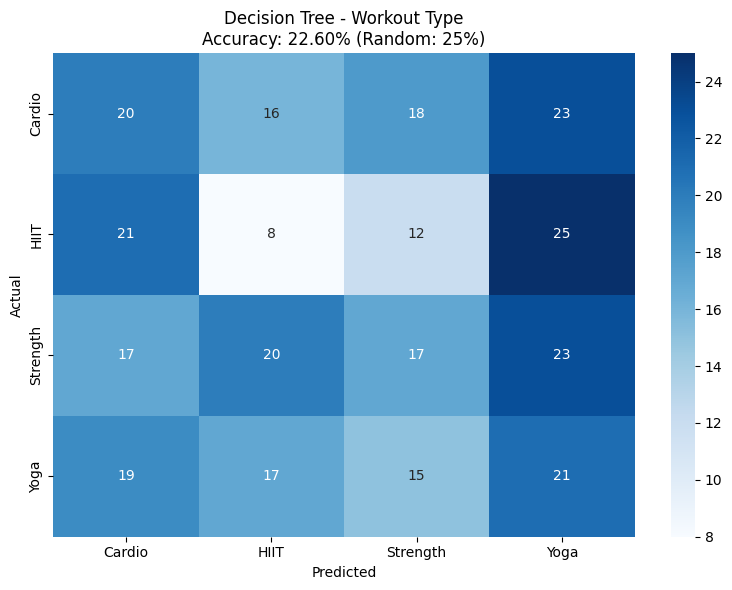

In [11]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le_workout.classes_, yticklabels=le_workout.classes_)
plt.title(f'Decision Tree - Workout Type\nAccuracy: {test_acc:.2%} (Random: 25%)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('dt_workout_confusion_matrix.png', dpi=150)
plt.show()

In [12]:
print('\n' + '='*70)
print('SONUÇ: WORKOUT TYPE TAHMİNİ BAŞARISIZ')
print('='*70)
print(f'Accuracy: {test_acc*100:.2f}% ≈ Rastgele şans (25%)')
print('ANOVA analizi doğrulandı')


SONUÇ: WORKOUT TYPE TAHMİNİ BAŞARISIZ
Accuracy: 22.60% ≈ Rastgele şans (25%)
ANOVA analizi doğrulandı


In [13]:
grid_search_f1 = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

grid_search_f1.fit(X_train, y_train)

print("Best params (F1):", grid_search_f1.best_params_)
print("Best CV Macro F1:", grid_search_f1.best_score_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best params (F1): {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 5}
Best CV Macro F1: 0.2922998102668818


In [14]:
dt_balanced = DecisionTreeClassifier(
    criterion='gini',
    max_depth=10,
    min_samples_split=5,
    class_weight='balanced',
    random_state=42
)

scores = cross_val_score(
    dt_balanced,
    X, y,
    cv=5,
    scoring='accuracy'
)

print("Balanced DT CV Accuracy:", scores.mean())


Balanced DT CV Accuracy: 0.24871794871794872


In [15]:
reduced_features = [
    'Session_Duration (hours)',
    'Workout_Frequency (days/week)',
    'Calories_Burned',
    'Avg_BPM',
    'Max_BPM',
    'HRR',
    'Efficiency'
]

X_red = df[reduced_features]

scores = cross_val_score(
    DecisionTreeClassifier(max_depth=6, random_state=42),
    X_red, y,
    cv=5,
    scoring='accuracy'
)

print("Reduced Feature CV Accuracy:", scores.mean())


Reduced Feature CV Accuracy: 0.25076923076923074


DECISION TREE – WORKOUT TYPE PREDICTION
İYİLEŞTİRME DENEMELERİ VE NİHAİ DEĞERLENDİRME
1) Model İyileştirme Denemelerinin Özeti
Workout Type tahmini için Decision Tree modeli üzerinde çeşitli iyileştirme adımları uygulanmıştır. Bu kapsamda hiperparametre optimizasyonu, değerlendirme metriği değişimi (accuracy → macro F1), sınıf ağırlıklandırması (class_weight='balanced') ve özellik azaltımı gibi yöntemler sistematik olarak denenmiştir. Amaç, model kapasitesinden bağımsız olarak hedef değişkenin öğrenilebilirliğini test etmektir.
2) Metrik ve Model Bağımsız Tutarlılık
Accuracy ve macro F1 skorları kullanılarak yapılan çapraz doğrulama sonuçları incelendiğinde, her iki metrikte de elde edilen performansın rastgele tahmin seviyesine yakın kaldığı görülmüştür. Değerlendirme metriğinin değiştirilmesi, model performansında anlamlı bir iyileşme sağlamamıştır. Bu durum, düşük başarının metrik seçiminden kaynaklanmadığını göstermektedir.
3) Class Weight ve Feature Reduction Sonuçları
Sınıf ağırlıklandırması uygulanarak modelin sınıflara daha adil yaklaşması sağlanmaya çalışılmış, ancak bu yaklaşım da performansı anlamlı şekilde artırmamıştır. Benzer şekilde, yalnızca fizyolojik ve antrenman yoğunluğu ile ilişkili özellikler kullanılarak yapılan feature reduction denemelerinde de doğruluk rastgele tahmin seviyesinde kalmıştır. Bu sonuçlar, başarısızlığın feature sayısından veya dengesinden değil, feature–target ilişkisinin zayıflığından kaynaklandığını göstermektedir.
4) Confusion Matrix Analizi
Confusion matrix incelendiğinde, modelin belirli bir sınıfa aşırı yönelmediği ancak sınıflar arasında sistematik bir ayrım da yapamadığı görülmektedir. Yanlış sınıflandırmaların rastgele dağılması, modelin belirli bir karar mantığı geliştiremediğini ve öğrenilebilir bir örüntü bulunmadığını ortaya koymaktadır.
5) Genel Sonuç
Sonuç olarak, Decision Tree modeli üzerinde yapılan tüm iyileştirme denemelerine rağmen Workout Type tahmininde elde edilen performans rastgele tahmin seviyesinin üzerine çıkamamıştır. Bu durum, problemin model yetersizliğinden ziyade hedef değişkenin mevcut fizyolojik ve seans bazlı özelliklerle zayıf ilişkili olmasından kaynaklandığını göstermektedir. ANOVA analiz sonuçları da bu bulguyu desteklemekte olup, Workout Type değişkeninin bu veri seti için uygun bir sınıflandırma hedefi olmadığı sonucuna varılmıştır.